# Sentiment Scoring and Embeddings

In [1]:
import os
from pathlib import Path

from src.config import Config
from src.data import load_news, load_price, merge_price_news
from src.sentiment import FinBERT
from src.utils import save_csv, set_seed
from src.plots import plot_sentiment_trend

In [2]:
cfg = Config(Path("../config/config.yaml"))
rng = set_seed(cfg.runtime.seed)

2025-08-20 15:49:54,006 - INFO - src.utils - Global random seed set to 42


In [3]:
price = load_price(Path(cfg.data.raw_dir) / cfg.data.name_prices)
news = load_news(Path(cfg.data.raw_dir) / cfg.data.name_news)

In [4]:
news.head()

,date,rank,headline
0,2008-08-08,top1,"b""Georgia 'downs two Russian warplanes' as cou..."
1,2008-08-08,top13,"b""So---Russia and Georgia are at war and the N..."
2,2008-08-08,top18,"b'Condoleezza Rice: ""The US would not act to p..."
3,2008-08-08,top3,b'Russia Today: Columns of troops roll into So...
4,2008-08-08,top25,"b""No Help for Mexico's Kidnapping Surge"""


In [5]:
finbert = FinBERT(config=cfg, max_embedding_dims=17)
df_with_sentiment = finbert.transform(news[["date", "headline"]])
daily_sentiment = finbert.aggregate_daily(df_with_sentiment)
daily_sentiment.drop(columns=["headline_count"], inplace=True)
daily_sentiment.head()

2025-08-20 15:49:56,719 - INFO - FinBERT - Loaded FinBERT model: yiyanghkust/finbert-tone on cuda
2025-08-20 15:49:56,723 - INFO - src.utils - Global random seed set to 42
FinBERT Batch Processing: 100%|██████████| 1554/1554 [00:47<00:00, 32.40it/s]


,date,pos,neu,neg,pos_minus_neg,emb_0,emb_1,emb_2,emb_3,emb_4,...,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16
0,2008-08-08,0.080308,0.723097,0.196594,-0.116286,-0.482626,-0.328239,-0.636478,0.627401,0.294770,...,0.151610,-0.232541,0.348419,0.543224,-0.179494,0.553609,-0.347092,-0.518843,0.684280,0.227482
1,2008-08-11,0.168894,0.695768,0.135338,0.033555,-0.566419,-0.423188,-0.652022,0.812345,0.474358,...,0.135462,-0.261237,0.484763,0.363776,-0.225049,0.529768,-0.494232,-0.317024,0.633304,0.377935
2,2008-08-12,0.040929,0.696532,0.262539,-0.221610,-0.631328,-0.305491,-0.709601,0.736141,0.427515,...,0.295696,-0.275410,0.380731,0.385763,-0.265997,0.593549,-0.534134,-0.397291,0.669396,0.230531
3,2008-08-13,0.003527,0.833299,0.163175,-0.159648,-0.369901,-0.184175,-0.789519,0.645993,0.350836,...,0.166847,-0.208769,0.382932,0.774060,-0.113826,0.511805,-0.298713,-0.347355,0.684939,0.299247
4,2008-08-14,0.022426,0.928612,0.048962,-0.026536,-0.482822,-0.254288,-0.716074,0.775566,0.416154,...,0.036605,-0.267980,0.408606,0.557198,-0.188280,0.686246,-0.483639,-0.340268,0.713771,0.236775


In [6]:
df = merge_price_news(price, daily_sentiment)
df.head()

,date,open,high,low,close,volume,adj_close,pos,neu,neg,...,emb_7,emb_8,emb_9,emb_10,emb_11,emb_12,emb_13,emb_14,emb_15,emb_16
0,2008-08-08,11432.089844,11759.959961,11388.040039,11734.320312,212830000,11734.320312,0.080308,0.723097,0.196594,...,0.151610,-0.232541,0.348419,0.543224,-0.179494,0.553609,-0.347092,-0.518843,0.684280,0.227482
1,2008-08-11,11729.669922,11867.110352,11675.530273,11782.349609,183190000,11782.349609,0.168894,0.695768,0.135338,...,0.135462,-0.261237,0.484763,0.363776,-0.225049,0.529768,-0.494232,-0.317024,0.633304,0.377935
2,2008-08-12,11781.700195,11782.349609,11601.519531,11642.469727,173590000,11642.469727,0.040929,0.696532,0.262539,...,0.295696,-0.275410,0.380731,0.385763,-0.265997,0.593549,-0.534134,-0.397291,0.669396,0.230531
3,2008-08-13,11632.809570,11633.780273,11453.339844,11532.959961,182550000,11532.959961,0.003527,0.833299,0.163175,...,0.166847,-0.208769,0.382932,0.774060,-0.113826,0.511805,-0.298713,-0.347355,0.684939,0.299247
4,2008-08-14,11532.070312,11718.280273,11450.889648,11615.929688,159790000,11615.929688,0.022426,0.928612,0.048962,...,0.036605,-0.267980,0.408606,0.557198,-0.188280,0.686246,-0.483639,-0.340268,0.713771,0.236775


In [7]:
os.makedirs(cfg.data.processed_dir, exist_ok=True)
save_csv(Path(cfg.data.processed_dir) / cfg.data.name_prices_sentiment, df)

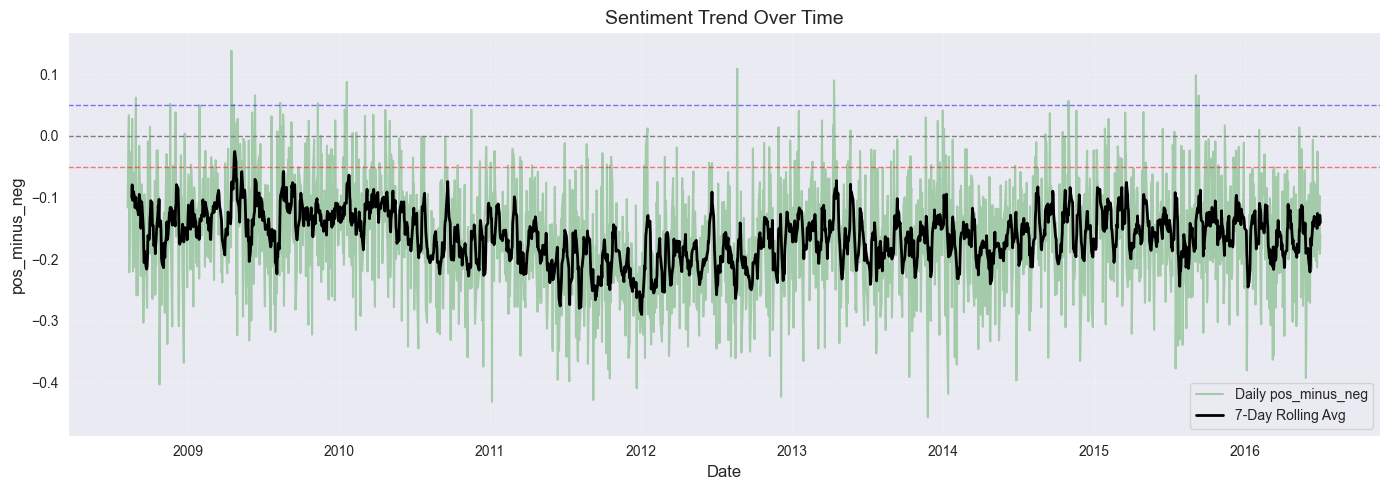

In [8]:
plot_sentiment_trend(daily_sentiment, Path(cfg.data.fig_dir) / "sentiment_trend.png")